# Modules Associated with Time Point and Diagnosis

**Created**: 20 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("rstatix")) {
    install.packages("rstatix")
}

Loading required namespace: patchwork

Loading required namespace: rstatix



In [2]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(rstatix)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




## Load Data

In [3]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt") %>%
    dplyr::mutate(supplier_name=gsub("^GA", "", supplier_name)) %>%
    dplyr::filter(supplier_name %in% rownames(eigengenes)) %>%
    dplyr::mutate(Time.Point=as.numeric(gsub("^.*_", "", supplier_name)))

rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]

In [4]:
clinical <- read.csv("04_Expression/data/clindata_2022-06-21_11-08-38.csv") %>%
    dplyr::select(Subject=1, Visit, Diagnosis) %>%
    dplyr::mutate(Subject=gsub("^GA", "", Subject)) %>%
    dplyr::mutate(Visit=as.numeric(gsub("Day ", "", Visit))) %>%
    dplyr::mutate(ID=paste0(Subject, "_", Visit))

rownames(clinical) <- clinical$ID

## Association with Time Point

I used a repeated measures ANOVA (which is an extension of the paired $t$-test) to test for association between eigengenes and time points.

In [6]:
eigen.time.data <- sample.info %>%
    dplyr::select(GAinSID, Time.Point, supplier_name) %>%
    merge(., eigengenes, by.x="supplier_name", by.y=0)

In [7]:
test.results <- list()
test.results[["P.Value"]] <- list()
test.results[["GES"]] <- list()

for (eigengene in variance.explained$Module) {

    res <- eigen.time.data %>%
        anova_test(dv=lazyeval::interp(eigengene), wid=GAinSID, within=Time.Point) %>%
        get_anova_table()
  
    test.results[["P.Value"]][[eigengene]] <- res$p
    test.results[["GES"]][[eigengene]] <- res$ges
}

associated.eigengenes <- lapply(test.results, unlist) %>%
    as.data.frame() %>%
    dplyr::mutate(Eigengene=rownames(.)) %>%
    dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
    dplyr::arrange(desc(GES)) %>%
    dplyr::mutate(Association.Variable="D1/D3/D5", Association.Variable.Type="Time Point", Statistic.Type="Generalized Effect Size") %>%
    dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=GES, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(associated.eigengenes, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.time.point.association.csv")

In [8]:
head(associated.eigengenes)

,Eigengene,Association.Variable,Association.Variable.Type,Statistic,Statistic.Type,P.Value,Adjusted.P.Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ME_44,ME_44,D1/D3/D5,Time Point,0.236,Generalized Effect Size,5.89e-06,0.0003259500
ME_45,ME_45,D1/D3/D5,Time Point,0.192,Generalized Effect Size,1.76e-05,0.0004664000
ME_49,ME_49,D1/D3/D5,Time Point,0.175,Generalized Effect Size,5.55e-05,0.0009805000
ME_8,ME_8,D1/D3/D5,Time Point,0.163,Generalized Effect Size,2.31e-05,0.0004897200
ME_75,ME_75,D1/D3/D5,Time Point,0.147,Generalized Effect Size,1.19e-05,0.0004204667
ME_19,ME_19,D1/D3/D5,Time Point,0.146,Generalized Effect Size,2.26e-04,0.0028427273


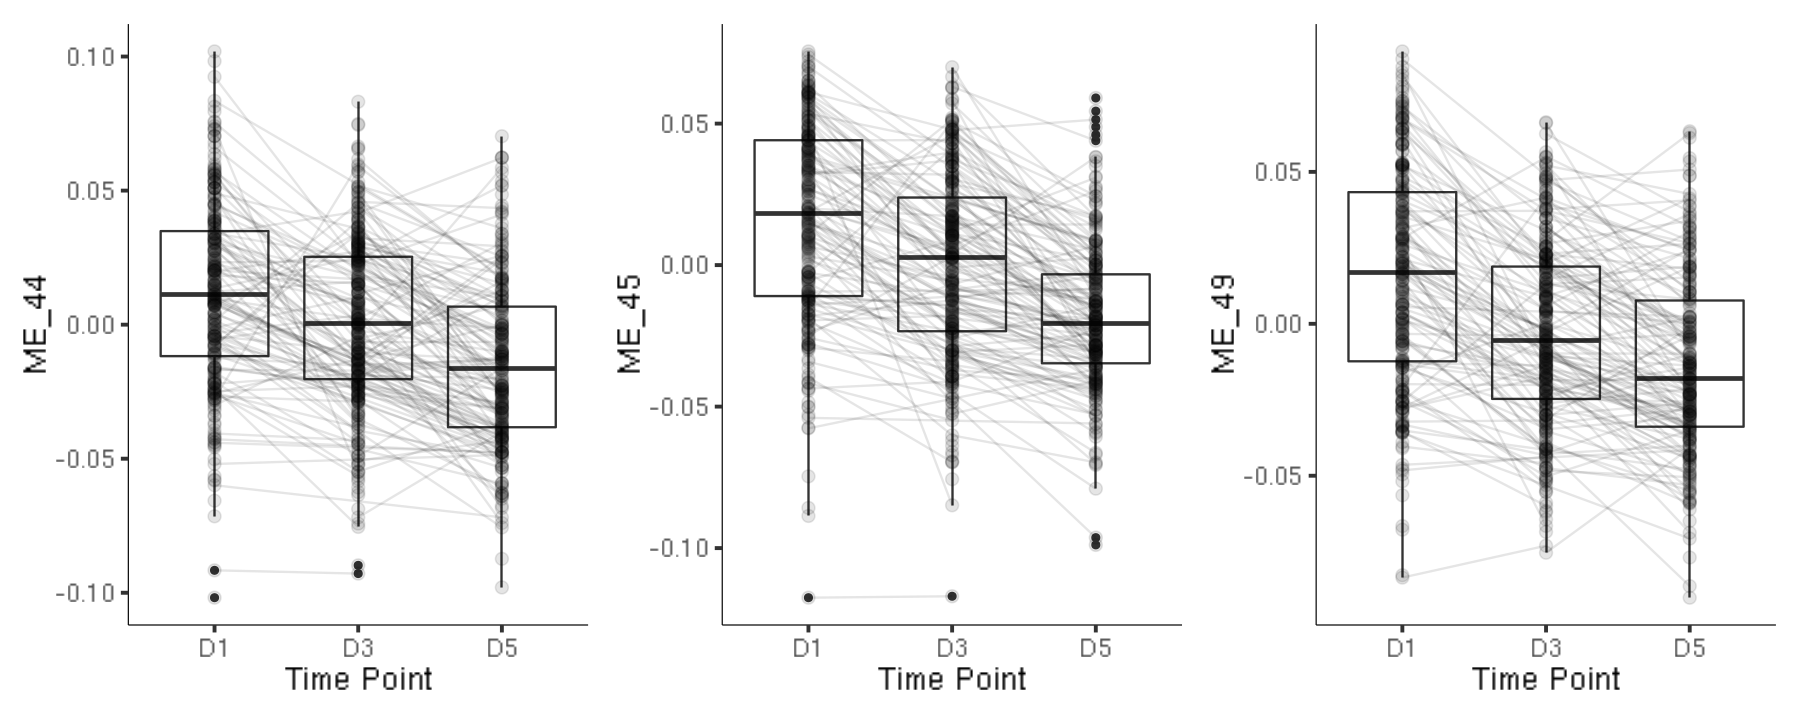

In [9]:
plots <- lapply(c("ME_44", "ME_45", "ME_49"), function(eigengene) {
    eigen.time.data %>%
        dplyr::mutate(Time.Point=factor(paste0("D", Time.Point))) %>%
        ggplot(aes_string(x="Time.Point", y=eigengene, group="GAinSID")) +
        geom_boxplot(aes(group=Time.Point)) +
        geom_line(alpha=0.1) +
        geom_point(size=I(3), alpha=0.1) +
        xlab("Time Point") +
        ggplot_theme
})

options(repr.plot.width=15, repr.plot.height=6)
wrap_plots(plots)
ggsave("04_Expression/results/eigengene_association_with_time_point.svg", width=15, height=6)

## Association with Diagnosis

In [10]:
eigen.diagnosis.data <- merge(clinical, eigengenes, by.x="ID", by.y=0)

In [11]:
test.results <- list()
test.results[["P.Value"]] <- list()
test.results[["Prop.Var"]] <- list()

for (eigengene in colnames(eigengenes)) {
    
    test.res = eigen.diagnosis.data %>%
        anova_test(dv=lazyeval::interp(eigengene), wid=Subject, between=Diagnosis) %>%
        get_anova_table() %>%
        suppressMessages()
    
    test.results[["Prop.Var"]][[eigengene]] <- test.res$ges
    test.results[["P.Value"]][[eigengene]] <- test.res$p
}

test.results[["P.Value"]] <- unlist(test.results[["P.Value"]])
test.results[["Prop.Var"]] <- unlist(test.results[["Prop.Var"]])

In [12]:
associated.eigengenes <- as.data.frame(test.results) %>%
    dplyr::mutate(Eigengene=rownames(.)) %>%
    dplyr::mutate(Association.Variable="Diagnosis", Association.Variable.Type="Diagnosis", Statistic.Type="GES") %>%
    dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
    dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Prop.Var, Statistic.Type, P.Value, Adjusted.P.Value) %>%
    dplyr::arrange(P.Value)

write.csv(associated.eigengenes, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.diagnosis.association.csv")

In [13]:
head(associated.eigengenes)

,Eigengene,Association.Variable,Association.Variable.Type,Statistic,Statistic.Type,P.Value,Adjusted.P.Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ME_92,ME_92,Diagnosis,Diagnosis,0.203,GES,8.42e-44,8.925200e-42
ME_39,ME_39,Diagnosis,Diagnosis,0.197,GES,1.91e-42,1.012300e-40
ME_23,ME_23,Diagnosis,Diagnosis,0.150,GES,7.89e-32,2.310800e-30
ME_81,ME_81,Diagnosis,Diagnosis,0.149,GES,8.72e-32,2.310800e-30
ME_19,ME_19,Diagnosis,Diagnosis,0.101,GES,1.42e-21,3.010400e-20
ME_49,ME_49,Diagnosis,Diagnosis,0.094,GES,5.30e-20,9.363333e-19
